<a href="https://colab.research.google.com/github/jashvidesai/ORF-Thesis/blob/main/CVRP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
!pip install gurobipy

In [58]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np

# Example parameters
V = range(6)  # nodes including depot, 0 is depot
V_star = range(1, 6)  # nodes excluding depot
K = range(3)
Q = 55

# DISTANCES
np.random.seed(42)
distances = np.random.randint(10, 51, size=(len(V), len(V)))
# distance matrix symmetric and set the diagonal to 0
for i in V:
    distances[i, i] = 0
    for j in range(i + 1, len(V)):
        distances[j, i] = distances[i, j]

# triangle inequality enforced
for i in V:
    for j in V:
        for k in V:
            if distances[i, j] > distances[i, k] + distances[k, j]:
                distances[i, j] = distances[i, k] + distances[k, j]

# $0.15/mile is the average American cost for gas as per New York Times
c = distances * 0.093

# Sample demands (including depot which has 0 demand)
d = [0, 30, 35, 20, 25, 30]

# Model setup
model = gp.Model("CVRP")

# Decision variables
x = model.addVars(V, V, vtype=GRB.BINARY, name="x")  # binary variable
q = model.addVars(V, vtype=GRB.CONTINUOUS, name="q")  # continuous variable

# objective fn.
model.setObjective(gp.quicksum(c[i, j] * x[i, j] for i in V for j in V), GRB.MINIMIZE)

# constraints

# constraint 1, 2
for j in V_star:
    model.addConstr(gp.quicksum(x[i, j] for i in V) == 1, name=f"visit_{j}")
for i in V_star:
    model.addConstr(gp.quicksum(x[i, j] for j in V) == 1, name=f"departure_{i}")

# constraint 3, 4
model.addConstr(gp.quicksum(x[i, 0] for i in V_star) <= len(K), name="vehicle_out")
model.addConstr(gp.quicksum(x[0, j] for j in V_star) <= len(K), name="vehicle_in")

# constraint 5 (fleet size)
model.addConstr(gp.quicksum(x[0, j] for j in V_star) <= np.ceil(sum(d[i] for i in V_star) / Q), name="fleet_capacity")

# constraint 6 (set depot demand 0)
model.addConstr(q[0] == 0, name="depot_demand")

# compute M and M_2
M = {(i, j): Q - (d[i] + d[j]) if i != j else 0 for i in V_star for j in V_star}

# constraint 7, 8, 9 (subtour elimination)
model.addConstrs((q[i] + d[j] <= q[j] + Q * (1 - x[i, j]) for i in V_star for j in V_star), name="load_balance1")
model.addConstrs((q[i] + d[j] >= q[j] - M[i, j] * (1 - x[i, j]) for i in V_star for j in V_star), name="load_balance2")
model.addConstrs((q[i] >= d[i] for i in V_star), name="demand_lower_bound")
model.addConstrs((q[i] <= Q for i in V_star), name="demand_upper_bound")

# solve
model.optimize()

# output
if model.status == GRB.OPTIMAL:
    solution = model.getAttr('x', x)
    for i in V:
        for j in V:
            if solution[i, j] > 0.5:
                print(f"Edge ({i}, {j}) is in the optimal route with cost {c[i, j]}")
    satisfied_demand = model.getAttr('x', q)
    for i in V:
        print(f"Demand satisfied at node {i}: {satisfied_demand[i]}")
else:
    print("No optimal solution found.")

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 74 rows, 42 columns and 205 nonzeros
Model fingerprint: 0x8b7b7250
Variable types: 6 continuous, 36 integer (36 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+01]
  Objective range  [1e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+01]
Found heuristic solution: objective 20.6460000
Presolve removed 50 rows and 20 columns
Presolve time: 0.01s
Presolved: 24 rows, 22 columns, 105 nonzeros
Variable types: 4 continuous, 18 integer (18 binary)

Root relaxation: objective 1.790003e+01, 28 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   17

In [59]:
import matplotlib.pyplot as plt
import networkx as nx

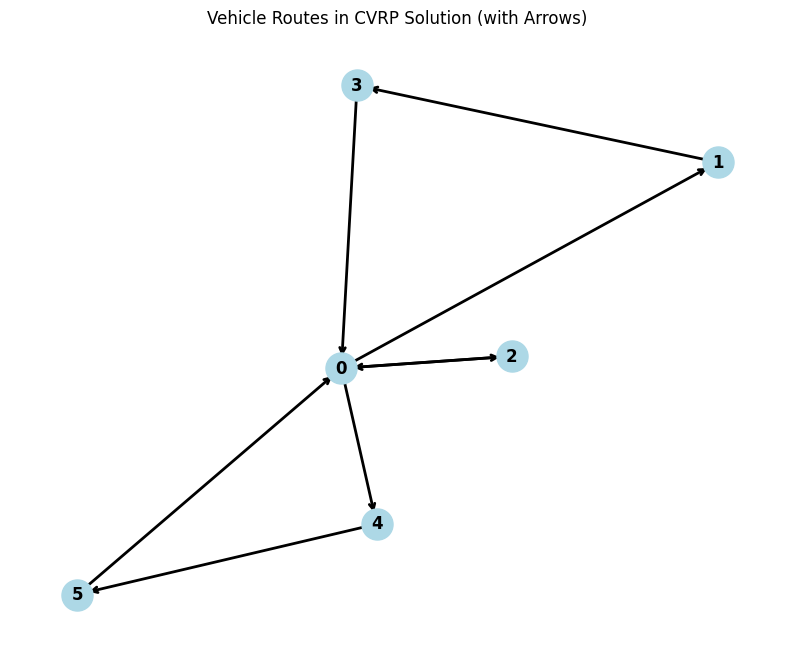

In [62]:
# Create a graph for visualization using NetworkX
G = nx.DiGraph()  # Directed graph to represent routes with arrows

# Add nodes to the graph
for node in V:
    G.add_node(node, pos=(np.random.rand() * 100, np.random.rand() * 100))  # random positions

# Add edges for the optimal route
edges_in_route = []
if model.status == GRB.OPTIMAL:
    solution = model.getAttr('x', x)
    for i in V:
        for j in V:
            if solution[i, j] > 0.5:  # If edge (i, j) is in the optimal route
                G.add_edge(i, j)
                edges_in_route.append((i, j))

# Identify connected components in the graph
connected_components = list(nx.weakly_connected_components(G))  # Use weakly_connected_components for directed graph

# Get positions of nodes for plotting
pos = nx.get_node_attributes(G, 'pos')

# Draw the graph
plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue')
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')


# Highlight each route with a different color and add arrows
for idx, component in enumerate(connected_components):
    subgraph_edges = [(u, v) for u, v in edges_in_route if u in component and v in component]
    nx.draw_networkx_edges(
        G, pos, edgelist=subgraph_edges, width=2,
        arrows=True, arrowstyle='->', label=f"Route {idx+1}"
    )

# Add legend
plt.title("Vehicle Routes in CVRP Solution (with Arrows)")
plt.axis("off")
plt.show()